In [1]:

import h5py
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import os
from qutip import*
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap as lsc
import time
from matplotlib.pyplot import figure, show
from matplotlib import gridspec
from tqdm.auto import tqdm # progress bar
from scipy.optimize import curve_fit
from tcsim.system import*
from tcsim.visualization import*

c:\Users\jonat\AppData\Local\pypoetry\Cache\virtualenvs\tcsim-vg60nFMD-py3.9\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import cvxpy as cp
import qutip as qt
from scipy.special import genlaguerre
from math import sqrt, factorial
import matplotlib.pyplot as plt
from scipy.linalg import lstsq, eigh, svd
from scipy.sparse.linalg import LinearOperator, lsqr
import h5py
from tqdm.auto import tqdm # progress bar
from matplotlib import colors
from tcsim.visualization import*
from tcsim.gates import*
from tcsim.system import*
from tcsim.analyze.dataloader import*

def vectorize(rho):
    """
    Turn hermitian matrix rho into a real vector
    vectorize(rho)[:d] = diag(rho)
    vectorize(rho)[d:d + d*(d-1)/2] = Re[upper_triangle(rho)]
    vectorize(rho)[d + d*(d-1)/2:]  = Im[upper_triangle(rho)]
    """
    d = rho.shape[0]  ## the shape of first column - dimension of matrix, e.g. 3x3 matrix d = 3
    n_offd = d*(d-1)//2 
    ret = np.zeros(d**2) #array of zeros with dimensionality d**2
    i = 0
    for m in range(d):
        ret[m] = rho[m, m].real #mth entry in ret is real part of (m,m) diagonal entry of matrix, capped at d
        for n in range(m+1, d):
            ret[d+i] = rho[m, n].real  #set d+ith entry in ret to real part of (m,n) off diagonal entry of matrix
            ret[d+n_offd+i] = rho[m, n].imag
            i += 1
    return ret


def matricize(rvec):
    """
    Invert the vectorize operation such that matricize(vectorize(rho)) == rho
    """
    d = int(np.sqrt(len(rvec)))
    n_offd = d*(d-1)//2
    ret = np.diag(rvec[:d]).astype(np.complex) # 将rvec[:d]转化为一个对角矩阵，并且用a+jb的形式表示
    i = 0
    for m in range(d):
        for n in range(m+1, d):
            real = rvec[d+i]
            imag = rvec[d+n_offd+i]
            val = real + 1j*imag
            ret[m, n] = val
            ret[n, m] = val.conj()
            i += 1
            
def char_ops(hilbert_size, betas):
    ops_list = []

    for beta in tqdm(betas):
        D = displace(100, beta) # need the larger Hilbert space to not get erroneous operators for large beta
        op = D
        op = Qobj(op[:hilbert_size, :hilbert_size]) # truncate to wanted Hilbert space size
        ops_list.append(op)

    return ops_list

def reconstruct_char_complex_convex(char, disps, dim):
    # construct vectors
    basis_vectors = []
    for i in range(dim):
        vector = fock(dim, i)
        basis_vectors.append(vector.full())

    # construct operators
    basis_dms = []
    for vector1 in basis_vectors:
        for vector2 in basis_vectors:
            dm = np.outer(vector2, vector1)
            basis_dms.append(dm)
    Pis = char_ops(dim, disps)
    A = np.zeros((len(Pis), dim*dim), dtype=complex)
    
    for index, a in tqdm(np.ndenumerate(A)):
        A[index] = np.trace(Pis[index[0]].full() @ basis_dms[index[1]])
    
    X = cp.Variable((dim,dim), hermitian=True)
    cost = cp.norm(A @ cp.reshape(X, (dim*dim)) - char, 2)
    constraints = [cp.trace(X) == 1, X >> 0]
    prob = cp.Problem(cp.Minimize(cost), constraints)
    prob.solve()
    reconstructed_rho = Qobj(X.value)
    return reconstructed_rho

def make_disps(xmax, N):
    xs = np.linspace(-xmax, xmax, N)
    X, Y = np.meshgrid(xs, xs)
    return (X + Y*1j).flatten()

In [13]:
def gauss_1(x, amp1, cen1, sigma1):
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2)))

def gauss_3(x, amp1, cen1, sigma1, amp2, cen2, sigma2, amp3, cen3, sigma3):
    """ Fitting Function"""
    return amp1 * (np.exp((-1.0 / 2.0) * (((x - cen1) / sigma1) ** 2))) + \
           amp2 * (np.exp((-1.0 / 2.0) * (((x - cen2) / sigma2) ** 2))) + \
           amp3 * (np.exp((-1.0 / 2.0) * (((x - cen3) / sigma3) ** 2)))
           
def extract_amps(xvec, data, p0, bounds, plot = False):
    popt, pcov = curve_fit(gauss_3, xvec,data, p0=p0, bounds=bounds)
    blob_amp = (popt[0]+popt[6])/2
    center_amp = popt[3]

    
    if plot:
        fig, axs = plt.subplots()
        axs.plot(xvec,data, 'b', label="given curve")
        axs.plot(xvec, gauss_3(xvec, *popt), ls=':', label="Fit function", linewidth=4, color='purple')
        for j, (a, c, s )in enumerate( popt.reshape(-1, 3)):
            axs.plot(xvec, gauss_1(xvec, a, c, s), ls='-', label=f"gauss {j+1}", linewidth=1, color='crimson')
        axs.legend()
        axs.autoscale(axis='x', tight=True)
    return blob_amp, center_amp
    


def load_data_single(d, filename, thresh, thresh_fac1 = 1, thresh_fac2 = 1, plot = True):
    
    files = [f for f in os.listdir(d) if f.endswith(filename)]

    #print(files)
    dg = []
    de = []

        #files = files[-5:-1]

    for kk in range(len(files)):
        fname = d + files[kk]
        df = h5py.File(fname, "r")
        data = df["data"]
        data_i = data["I"][:]
        x = data["x"][:, 0][:, 0]
        y = data["y"][0, :][:, 0] 
        n_points_x = len(x)  # sweep points x
        n_points_y = len(y)  # sweep points y
        thresh = thresh
        #ss_data = np.where(data_i < thresh, 1, 0)
        m0 = np.where(data_i[:, 0::3] < thresh*thresh_fac1, 1, 0)
        m1 = np.where(data_i[:, 1::3] < thresh*thresh_fac2, 1, 0)
        m2 = np.where(data_i[:, 2::3] < thresh, 1, 0)
        m1_g = ma.masked_array(m1, mask=m0)
        m2_g = ma.masked_array(m2, mask=m0)

        ## only care about last two measurements
        proj_g = ma.masked_array(m2, mask=m1).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1
        proj_e = ma.masked_array(m2, mask=np.logical_not(m1)).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1

        ## condition on the first measurement as well
        double_ps_g = ma.masked_array(m2_g, mask=m1_g).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1
        double_ps_e = ma.masked_array(m2_g, mask=np.logical_not(m1_g)).mean(axis=0).reshape(n_points_x, n_points_y) * 2 - 1

        dg.append(double_ps_g)
        de.append(double_ps_e)

        
    dg = np.array(dg)
    de = np.array(de)


    proj_g = dg.mean(axis=0)
    proj_e = de.mean(axis=0)
    proj_ge = [proj_g, proj_e]  # m2.mean(axis = 0).reshape(n_points, n_points)

    if plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
        f1 = ax1.pcolormesh(y, x, proj_g, cmap="seismic", vmax=1, vmin=-1)
        f2 = ax2.pcolormesh(y, x, proj_e, cmap="seismic", vmax=1, vmin=-1)
        ax1.set_aspect("equal")
        ax1.set_xlabel(r"real($\beta$)")
        ax1.set_ylabel(r"imag($\beta$)")
        ax1.set_title('proj_g')
        ax2.set_aspect("equal")
        ax2.set_xlabel(r"real($\beta$)")
        ax2.set_title('proj_e')
        # fig.colorbar(f2)
    return proj_g, x, y


def odd_cat(N,alpha):
    cat = (coherent(N,alpha) - coherent(N, -alpha)).unit()
    return cat

def reconstruct_dm(data,x, N):
    
    im = np.zeros((data.shape))
    data_with_im = data + 1j*im
    re_rho = reconstruct_char_complex_convex((data_with_im).flatten(),make_disps(np.max(x)*3,len(x)), N)
    rho = Qobj(re_rho)
    return rho




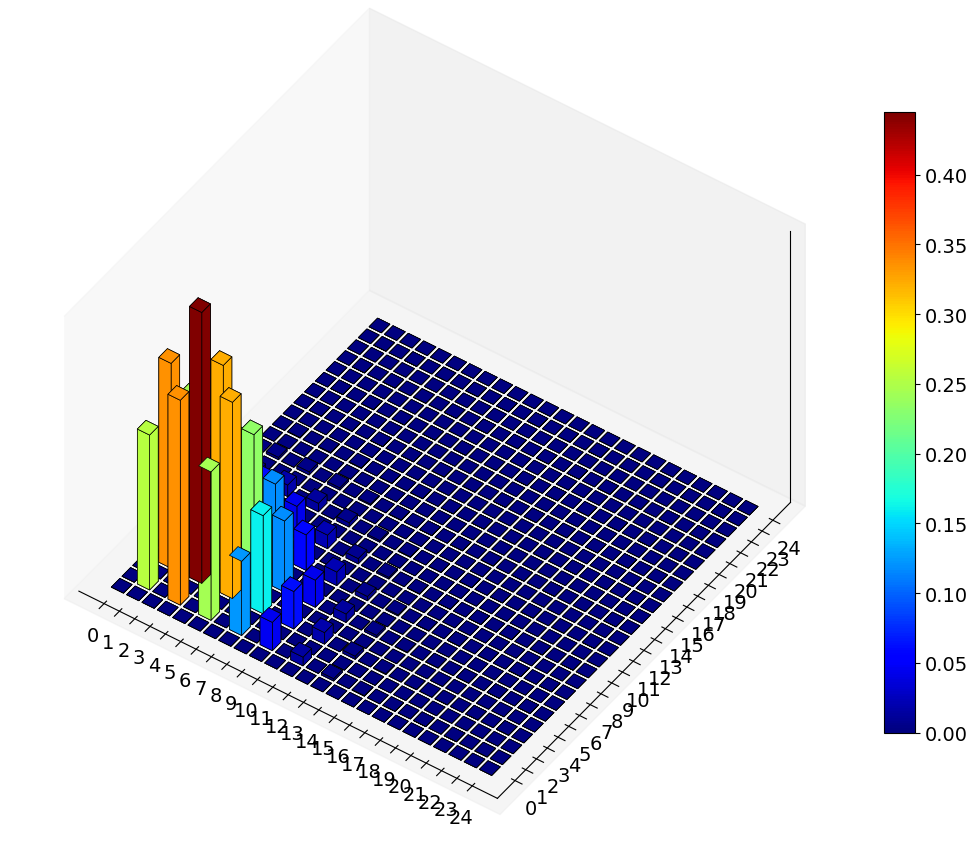

In [9]:
cat = odd_cat(1.8)

fig, ax = qt.matrix_histogram(ket2dm(cat))
ax.view_init(azim=-55, elev=45)
plt.show()

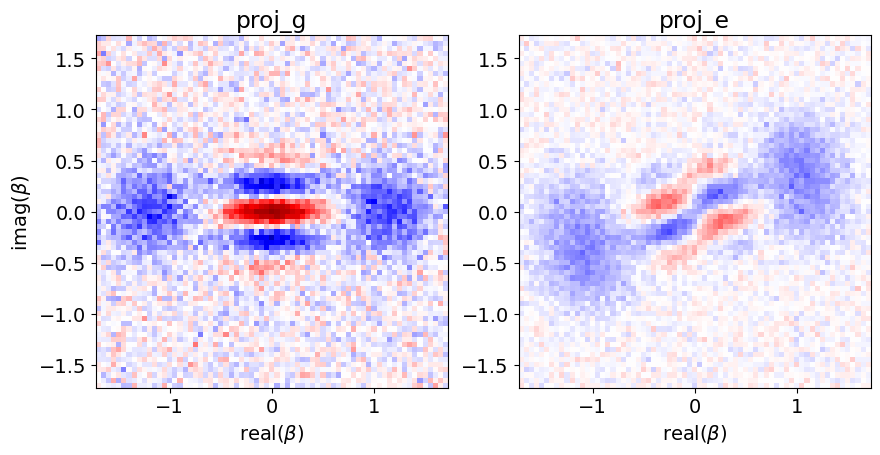

In [11]:
filename = 'panther_normal_cat_decay_loop_oddcat.h5' 
d = "C:/Users/jonat/Desktop/Coding/tcsim/data_analysis/data/all_data_new/fig3/"

thresh = 0.0002040

proj_g, x,y = load_data_single(d, filename, thresh, 1.2, 3)

In [33]:
p0 = [-0.5, -1.3, 1, 1, 0, 1, -0.5, 1.3, 1]
bounds = ([-1, -5, 0.2 ,0, -0.5, 0 ,-1, 0, 0.2], [0,2.5, 1.1 ,1, 0.5, 1.1 ,0, 5, 1.1])

vac_norm = 0.884
thresh_fac2_array = np.linspace(1,3,5)
blob_amps = []
center_amps = []
overlaps = []
cat = odd_cat(18, 1.75)

for thresh_fac2 in thresh_fac2_array:
    # use different threshold values
    proj_g, x, y = load_data_single(d, filename, 0.0002040,1.2,thresh_fac2, plot = False) 
    cut = proj_g[35,:]/vac_norm
    blob_amp, center_amp = extract_amps(x,cut, p0, bounds, plot=False)
    blob_amps.append(blob_amp)
    center_amps.append(center_amp)
    rho = reconstruct_dm(proj_g/vac_norm, x, 18 )
    overlap = expect(rho,cat)
    overlaps.append(overlap)
    print("thresh_fac2 = ", thresh_fac2)
    print("blob_amp =", blob_amp)
    print("center_amp =", center_amp)
    print("overlap =", overlap)
    print("    ")

100%|██████████| 4761/4761 [00:56<00:00, 84.09it/s] 
1542564it [00:25, 59542.60it/s]


thresh_fac2 =  1.0
blob_amp = -0.3894113580124071
center_amp = 0.8851406167762388
overlap = 0.781617009781219
    


100%|██████████| 4761/4761 [00:46<00:00, 101.67it/s]
1542564it [00:23, 65237.51it/s]


thresh_fac2 =  1.5
blob_amp = -0.39143609926546385
center_amp = 0.8899667888278953
overlap = 0.7860190080672481
    


100%|██████████| 4761/4761 [00:47<00:00, 101.10it/s]
1542564it [00:24, 63184.50it/s]


thresh_fac2 =  2.0
blob_amp = -0.38691823365955624
center_amp = 0.8799748595795378
overlap = 0.7853165083365415
    


100%|██████████| 4761/4761 [00:47<00:00, 100.61it/s]
1542564it [00:24, 64242.46it/s]


thresh_fac2 =  2.5
blob_amp = -0.395085090484671
center_amp = 0.8713660416515283
overlap = 0.7857359351694552
    


100%|██████████| 4761/4761 [00:46<00:00, 102.31it/s]
1542564it [00:24, 63911.56it/s]


thresh_fac2 =  3.0
blob_amp = -0.4141708581262785
center_amp = 0.8747525159433525
overlap = 0.78804943646081
    


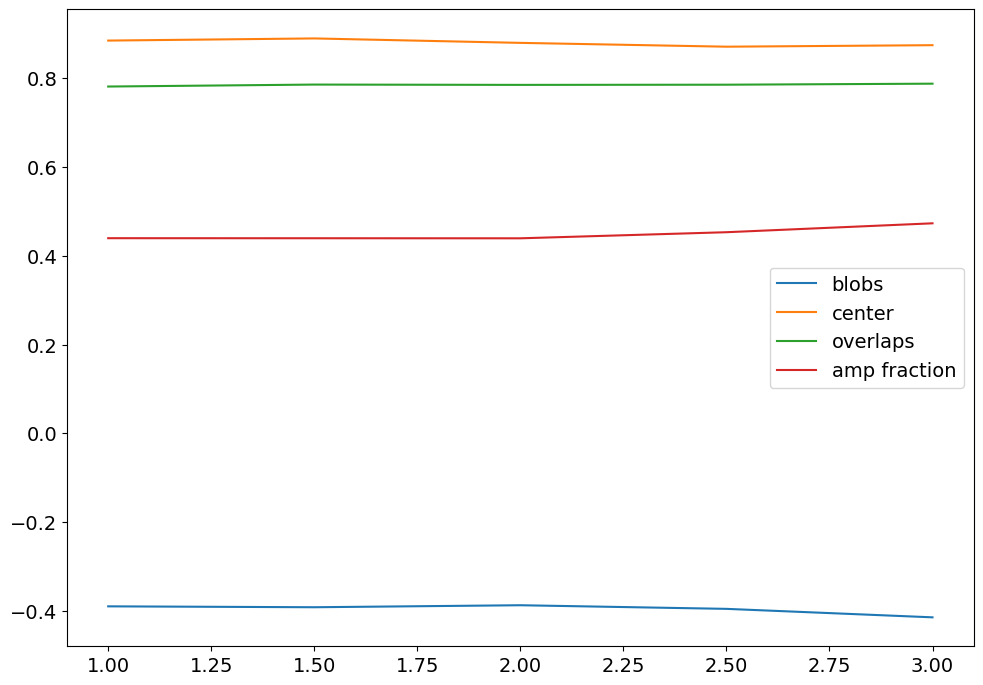

In [37]:
plt.plot(thresh_fac2_array, blob_amps, label = "blobs")
plt.plot(thresh_fac2_array, center_amps, label = "center")
plt.plot(thresh_fac2_array, overlaps, label = "overlaps")
plt.plot(thresh_fac2_array, -1*np.array(blob_amps)/np.array(center_amps), label = "amp fraction")
plt.legend()

In [38]:
print(overlaps)

[0.781617009781219, 0.7860190080672481, 0.7853165083365415, 0.7857359351694552, 0.78804943646081]


In [39]:
p0 = [-0.5, -1.3, 1, 1, 0, 1, -0.5, 1.3, 1]
bounds = ([-1, -5, 0.2 ,0, -0.5, 0 ,-1, 0, 0.2], [0,2.5, 1.1 ,1, 0.5, 1.1 ,0, 5, 1.1])

vac_norm = 0.884
thresh_fac2_array = np.linspace(3,5,5)
blob_amps = []
center_amps = []
overlaps = []
cat = odd_cat(18, 1.75)

for thresh_fac2 in thresh_fac2_array:
    # use different threshold values
    proj_g, x, y = load_data_single(d, filename, 0.0002040,1.2,thresh_fac2, plot = False) 
    cut = proj_g[35,:]/vac_norm
    blob_amp, center_amp = extract_amps(x,cut, p0, bounds, plot=False)
    blob_amps.append(blob_amp)
    center_amps.append(center_amp)
    rho = reconstruct_dm(proj_g/vac_norm, x, 18 )
    overlap = expect(rho,cat)
    overlaps.append(overlap)
    print("thresh_fac2 = ", thresh_fac2)
    print("blob_amp =", blob_amp)
    print("center_amp =", center_amp)
    print("overlap =", overlap)
    print("    ")

100%|██████████| 4761/4761 [00:49<00:00, 95.55it/s] 
1542564it [00:26, 58989.87it/s]


thresh_fac2 =  3.0
blob_amp = -0.4141708581262785
center_amp = 0.8747525159433525
overlap = 0.78804943646081
    


100%|██████████| 4761/4761 [00:52<00:00, 91.14it/s] 
1542564it [00:22, 67714.39it/s]


thresh_fac2 =  3.5
blob_amp = -0.37099718891513117
center_amp = 0.8670179444285054
overlap = 0.7891061848259032
    


100%|██████████| 4761/4761 [00:56<00:00, 84.09it/s] 
1542564it [00:28, 53306.84it/s]


thresh_fac2 =  4.0
blob_amp = -0.35431423336708295
center_amp = 0.9999999999999999
overlap = 0.7440201348954234
    


100%|██████████| 4761/4761 [00:57<00:00, 82.86it/s] 
1542564it [00:28, 55068.12it/s]


thresh_fac2 =  4.5
blob_amp = -0.2621342479248292
center_amp = 0.7492286582113658
overlap = 0.5119189955706538
    


100%|██████████| 4761/4761 [00:58<00:00, 81.26it/s] 
1542564it [00:26, 57514.60it/s]


thresh_fac2 =  5.0
blob_amp = -0.6008270447342346
center_amp = 0.9999999999694544
overlap = 0.17593199188284822
    


In [123]:
thresh_array = np.linspace(2e-4,2.5e-4, 50)
thresh_fac2_array = np.linspace(-0.5,0.5,1)

center_array = np.zeros((len(thresh_array),len(thresh_fac2_array)))
background = np.zeros((len(thresh_array),len(thresh_fac2_array)))
for i, thresh in enumerate(thresh_array):
    for j, thresh_fac2 in enumerate(thresh_fac2_array):
        proj_g, proj_e = load_data_single(d, filename, thresh,1.2,thresh_fac2, plot = False) 
        center_array[i][j] = np.max(proj_g)
        background[i,j] = proj_g[0:5,:].mean()
        

In [135]:
#thresh_array = np.linspace(1.5e-4,2e-4, 10)
thresh_fac2_array = np.linspace(1,4,50)
center_array = []
background = []
for thresh_fac2 in thresh_fac2_array:
    proj_g, proj_e = load_data_single(d, filename, 0.0002040,1.2,thresh_fac2, plot = False) 
    center_array.append(np.max(proj_g))
    background.append(proj_g[0:5,:].mean())
        

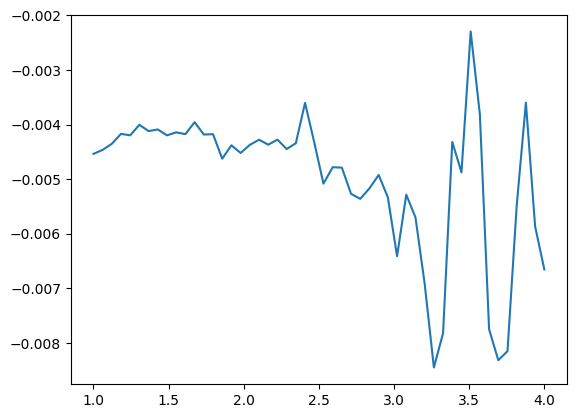

In [136]:
plt.plot(thresh_fac2_array, background)

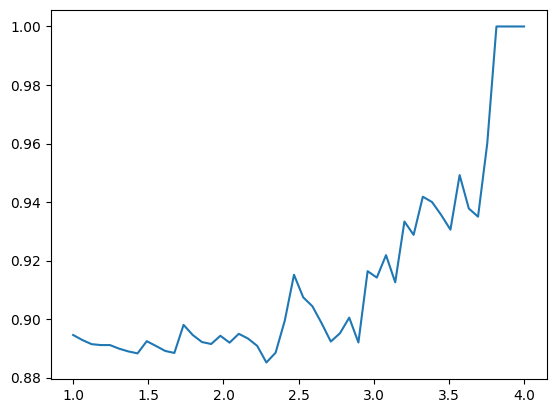

In [137]:
plt.plot(thresh_fac2_array, center_array)

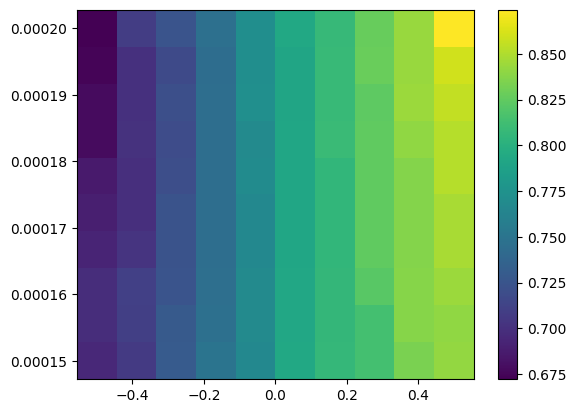

In [93]:
fig, ax = plt.subplots()
im = ax.pcolormesh(thresh_fac2_array, thresh_array, center_array, vmin = np.min(center_array), vmax = np.max(center_array))
fig.colorbar(im)

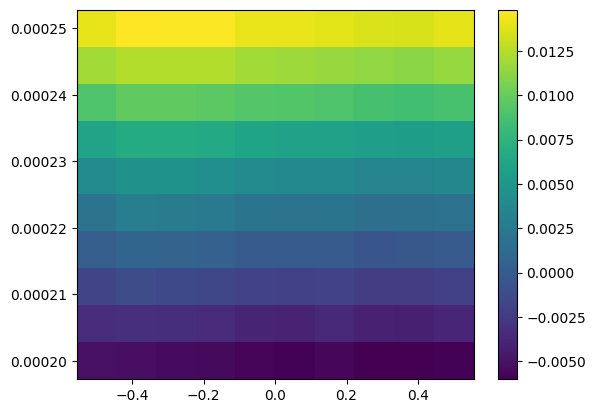

In [119]:
fig, ax = plt.subplots()
im = ax.pcolormesh(thresh_fac2_array, thresh_array,  background, vmin = np.min(background), vmax = np.max(background))
fig.colorbar(im)

In [124]:
np.argmin(abs(background[:,0]))

16

In [125]:
thresh_array[4]

0.00020408163265306123